In [497]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import unittest
import missingno as mn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import make_scorer, f1_score, precision_recall_curve, classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import RandomOverSampler
import plotly.express as px
np.random.seed(75)

# Summative 2

## Introduction

This analysis will apply three binary classification algorithms to borrower-level credit card data to estimate whether an individual will default in the following month or not. The ability to predict default will allow the lender to control cash-flow and take preventative action to help the borrower to not default.

The dataset contains information on both individual characteristics such as age, education and marriage status along with a range of financial attributes such as payment status and bill amount.

The analysis first explores, cleans and prepares the data. Then, three different types of classification models are used to predict the binary outcome: default or no default. The three different models are logistic regression, K-means clustering and a random forest model. Each model is evaluated using train-test splitting and based on their F1 score, although alternative metrics are considered and discussed. Oversampling techniques are also used to overcome imbalanced data.

For the K-means clustering and random forest models, we then also extend the analysis to consider hyperparameter tuning and cross-validation techniques to further improve those models.

We find that all 3 models are able to significant improve prediction compared to naive models. The best performing model is the Logisitic Regession model using oversampling. 

Finally, unit tests are implemented to test functions created in the code.

**To be aware: Approximately 20 minutes run time**


## 1. Data import

The [credit card data](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients) is available in the UCI Machine Learning Repository and was originally collected by Yeh and Lien (2009). 

First, the data is imported from a local file using the pandas package. The column headers are in the second row so the first row is skipped.

In [498]:
# Import the dataset 
raw_default = pd.read_excel('default_of_credit_card_clients.xls', skiprows=1)
raw_default.head(3)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0


## 2. Data exploration and cleaning

In [499]:
# Data shape
print(f' The data has {raw_default.shape[1]} columns and {raw_default.shape[0]} rows.')

 The data has 25 columns and 30000 rows.


The column names are cleaned first to ensure consistency throughout the analysis and ease of parsing.

In [500]:
# Rename columns
raw_default.rename(columns = {'default payment next month':'default'}, inplace=True)
raw_default.rename(columns = str.lower, inplace=True)
raw_default.head(3)

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0


### Duplicate rows

I first check that the 'id' variable is unique for each row.

In [501]:
# Check for duplicate id values
raw_default.loc[:,['id']].duplicated().value_counts() # False value id is not duplicated

False    30000
dtype: int64

Next, we look at the values across all columns excluding the id column to understand whether some rows have been identfied twice. While some individuals may have the exact same characteristics so it is not conclusive, I think it is still useful to check.

In [502]:
# Check for duplicates across exporter, importer and year
raw_default.drop(columns='id').duplicated().value_counts() # False value indicates row is not duplicated

False    29965
True        35
dtype: int64

There are 35 rows with the same values across all attributes (excluding id).

In [503]:
raw_default[raw_default.drop(columns='id').duplicated(keep = False) == True].sort_values(['limit_bal', 'age']).tail(5).iloc[:,12:25]

,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
25608,0,0,0,0,0,0,0,0,0,0,0,0,1
18,0,0,0,0,0,0,0,0,0,0,0,0,0
13106,0,0,0,0,0,0,0,0,0,0,0,0,0
839,0,0,0,0,0,0,0,0,0,0,0,0,1
7319,0,0,0,0,0,0,0,0,0,0,0,0,1


Manually looking at the rows (including those not shown here) we find many of the 'duplicated' rows are unused cards and therefore have zero bill and payment amounts. Given there is no evidence that these are definitely duplicates. I keep them in the analysis a they likely reflect the true distribution of the data.

### Missing and erroneous values

In [504]:
# Check for missing values
missing_val_count = raw_default.isnull().sum().sum() # the 2nd sum provides the value for the entire dataframe (rather than each column)
print(f'There are {missing_val_count} missing values in the raw_default dataframe.')

There are 0 missing values in the raw_default dataframe.


Here we can check the minimum and maximum values to understand if there are any erroneous entries, such as negative values where they're not expected.

In [505]:
raw_default.describe().T

,count,mean,std,min,25%,50%,75%,max
id,30000.0,15000.500000,8660.398374,1.0,7500.75,15000.5,22500.25,30000.0
limit_bal,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
sex,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
education,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
marriage,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
age,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
pay_0,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
pay_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
pay_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
pay_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0


We can see that some of the categorical values do not match those provided in Yeh and Lien (2009). As we don't understand the meaning of these rows, and they are erroneous, they are removed. In doing this we assume the out-of-sample entries would not have these errors. If they did, the model would not perform well on those observations.

We could potentially keep these values if they appear in the out-of-sample data however we would be unable to interpret the inputs and outputs.

In [506]:
# Dictionary of labelled values from paper
labeled_values = {
    'default': [0,1],
    'sex': [1,2],
    'education': [1,2,3,4],
    'marriage': [1,2,3],
    'pay': np.arange(-1,10)
}

# Create a copy of the dataframe that replaces erroneous values with missing (for later visualisations)
raw_default_missing = raw_default.copy()
# Filter the rows based on the dictionary of labeled values
for key, val in labeled_values.items():

    # Pull column with name in key
    filtered_col = [col for col in raw_default if key in col and 'amt' not in col]
    
    # Loop through each column in the filtered list
    for col in filtered_col:

        # Find the difference between the set of unique values and the values in the labeled_values dict
        not_found = set(raw_default[col]).difference(val)

        # If there is a difference, print the erroneous values found
        if not_found:
            print(f"Erroneous values found and removed from column {col}: {not_found}")

            # Replace erroneous values with missing in the missing df
            raw_default_missing[col] = raw_default[col].replace(not_found, np.NaN)
        
        # Filter the rows of the dataframe to only include those with values in the labeled_values dict
        raw_default = raw_default.loc[raw_default[col].isin(val)]

# Check value ranges match the dictionary values
raw_default.describe().T

Erroneous values found and removed from column education: {0, 5, 6}
Erroneous values found and removed from column marriage: {0}
Erroneous values found and removed from column pay_0: {-2}
Erroneous values found and removed from column pay_2: {-2}
Erroneous values found and removed from column pay_3: {-2}
Erroneous values found and removed from column pay_4: {-2}
Erroneous values found and removed from column pay_5: {-2}
Erroneous values found and removed from column pay_6: {-2}


,count,mean,std,min,25%,50%,75%,max
id,23150.0,14915.883499,8614.704376,2.0,7486.75,14897.5,22233.75,30000.0
limit_bal,23150.0,156266.681641,127582.332349,10000.0,50000.00,120000.0,220000.00,1000000.0
sex,23150.0,1.591533,0.491561,1.0,1.00,2.0,2.00,2.0
education,23150.0,1.852052,0.699916,1.0,1.00,2.0,2.00,4.0
marriage,23150.0,1.564363,0.518757,1.0,1.00,2.0,2.00,3.0
age,23150.0,35.243758,9.291339,21.0,28.00,34.0,41.00,79.0
pay_0,23150.0,0.180518,0.984888,-1.0,0.00,0.0,0.00,8.0
pay_2,23150.0,0.189028,1.034604,-1.0,0.00,0.0,0.00,8.0
pay_3,23150.0,0.174644,1.022299,-1.0,0.00,0.0,0.00,8.0
pay_4,23150.0,0.133391,0.988859,-1.0,0.00,0.0,0.00,8.0


From the count column we can see that the number of rows has decreased to 23,150 from 30,000.

Using the copied dataframe which has replaced the erroneous entries with missing values, we can use the missingno package to visualise how the erroneous values are related across columns.

<AxesSubplot: >

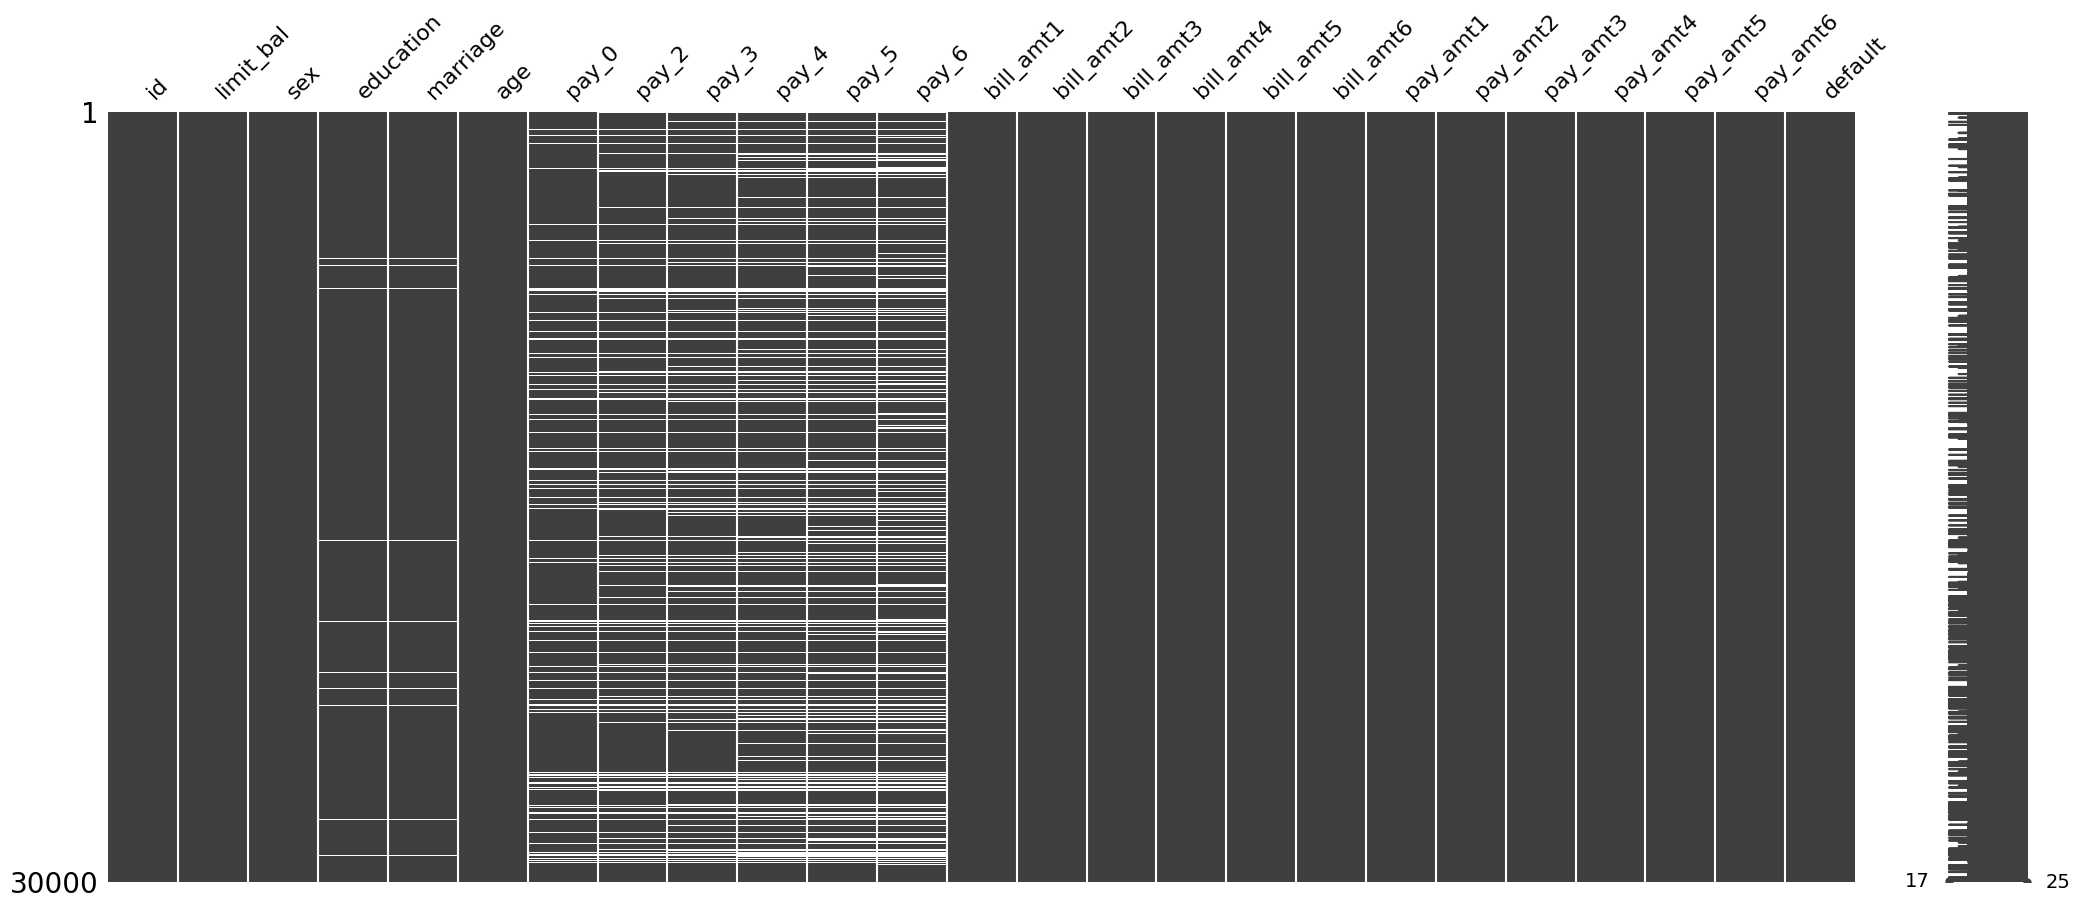

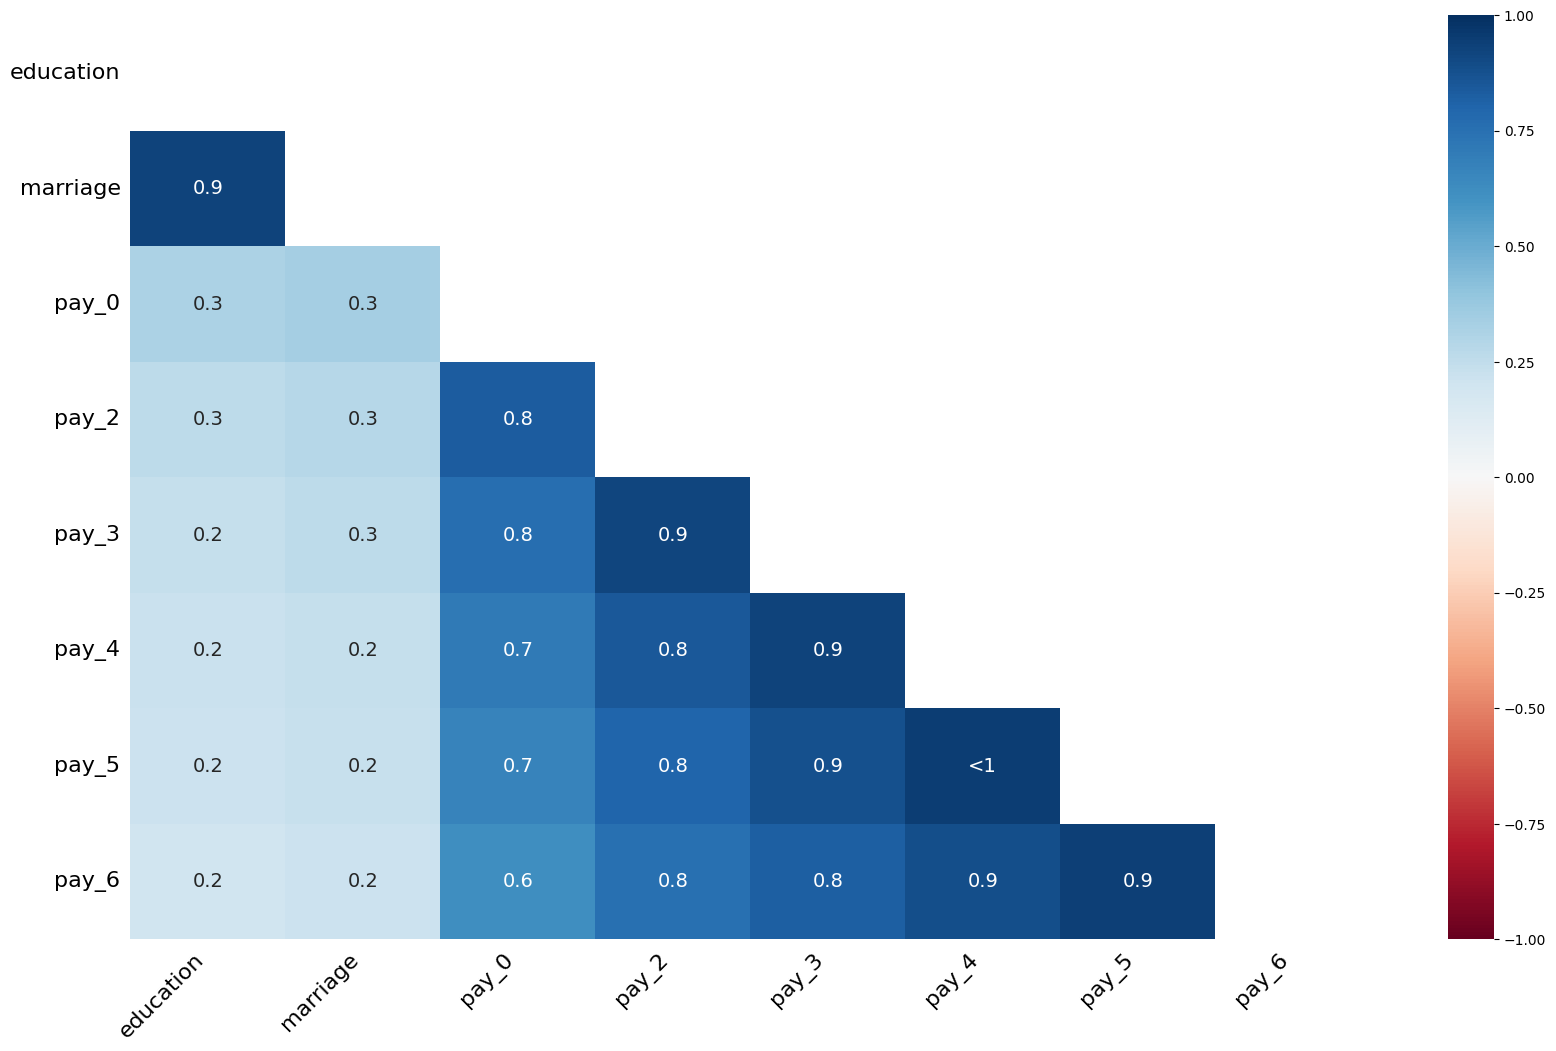

In [507]:
# Plot the missing values in the df
mn.matrix(raw_default_missing)

# Plot a correlation heat map for the missing values
mn.heatmap(raw_default_missing)

In [508]:
# Check for missing values 
raw_default_missing.isna().sum().loc[lambda x : x>0].sort_values(ascending=False) # only show columns with missing values

pay_6        6850
pay_5        6216
pay_4        5681
pay_3        5016
pay_2        4316
pay_0        3107
marriage      399
education     345
dtype: int64

In [509]:
# Check for missing values when rows with missing pay_6 are dropped
drop_pay_6 = raw_default_missing.dropna(axis = 0, subset = ['pay_6'])
pay_6_drop = drop_pay_6.isna().sum().sum()

print(f'After dropping erroneous values from pay_6, there are {pay_6_drop} erroneous values remaining.')

After dropping erroneous values from pay_6, there are 0 erroneous values remaining.


Here we can see that the erroneous values are associated with the same rows as all missing values are positively correlated to some extent. The "pay_x" columns are highly correlated. This is expected as borrowers payment status will be correlated over time. Interestingly, the education and marriage missing values are also highly correlated, this could be explained by some bank employees consistently inputting erroneous values together.

Removing the erroneous values removes 6850 rows from the dataset. An alternative would be to treat the values as missing and to use imputation to estimate the correct values. However, this would be difficult due to high correlation of missing values.

### Variable distributions and relationships

0    17788
1     5362
Name: default, dtype: int64


<AxesSubplot: xlabel='default', ylabel='count'>

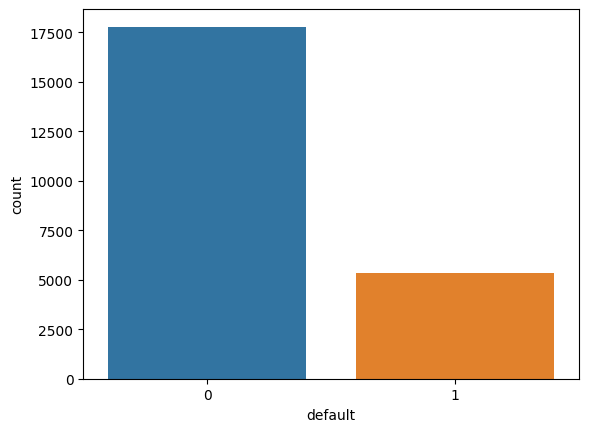

In [510]:
# Visualise the distribution of defaults to non-defaults
print(raw_default['default'].value_counts())
sns.countplot(raw_default, x='default')

Here we can see that the output variable is unbalanced - that is there are many more instances of non-default than there are default. Joshi (2002) finds that prediction models perform worse when applied to unbalanced datasets with unbalances greater than 1:10. Sun et al. (2009) finds that the impact is reduced when the training dataset is large.

The credit card data ratio is around 1:3 and the size of the training data is quite large (23,150 rows), this would suggest the data does not need over or undersampling techniques. However, we will re-evaluate this decision from the initial results.

I now use seaborn's catplot to understand how each attribute's distribution varies between the different outcomes. If the distributions are significantly different between the two outcomes, this might indicate the attribute being a good predictor of the outcome.

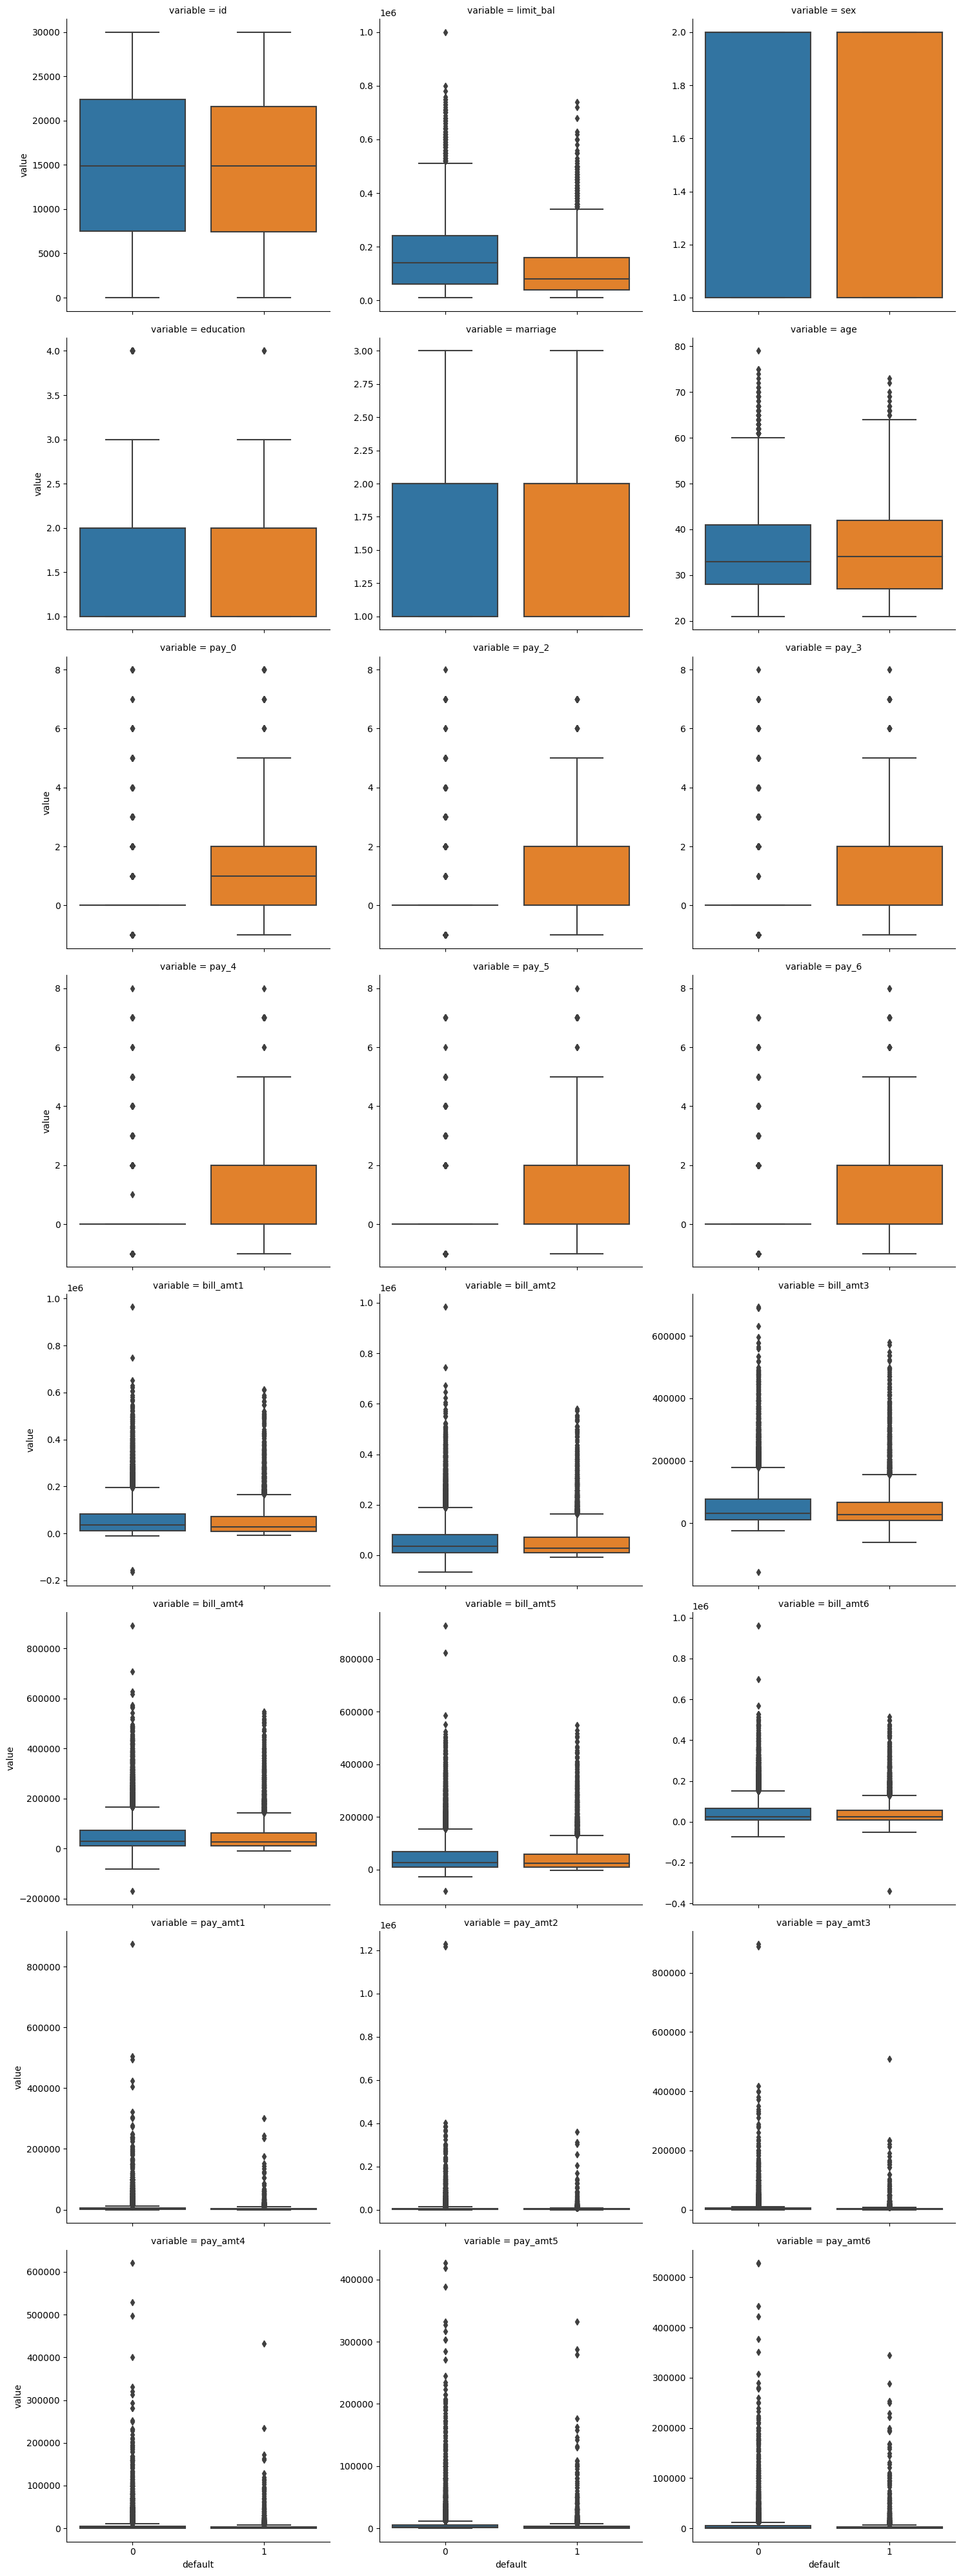

In [511]:
# Visualise the attribute distribution split by default type
raw_default_melt = raw_default.melt(id_vars='default')
sns.catplot(data = raw_default_melt, x='default', y='value', col='variable', kind='box', col_wrap=3, sharey=False)

From this visualisation, we can see that defaulters tend to have slightly smaller limit balances, but larger repayments especially in most recent months. Unsurprisingly the 'pay_x' variables - which indicate payment delay in previous months - show that defaulters are more likely to have been behind on payments in previous months.

We also see that many of numerical monetary variables are positively skewed. Some machine learning models may perform better when these variables are transfomred to have more normal distribution. One way of doing this would be to log transfrom, which would compress larger values (Hastie et al., 2009).

From this we can determine that the pay_X variables will likely be important predictors of default and shoult be included in the model.

The final piece of data exploration is to look at the correlation matrix between all variables.

<AxesSubplot: >

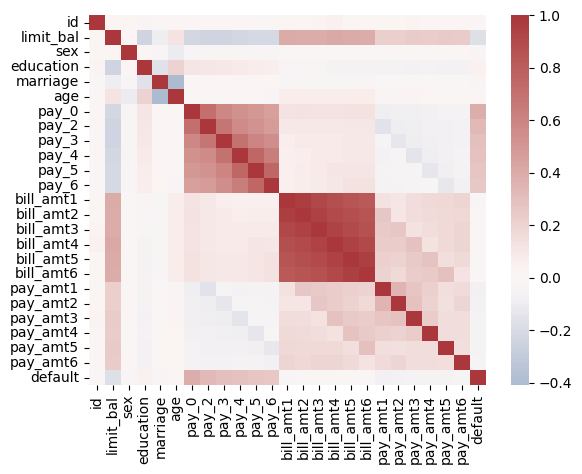

In [512]:
# Plot a correlation matrix
correlation = raw_default.corr()
sns.heatmap(correlation, cmap='vlag', center=0) # set the mid-point to zero

First focusing on the three financial groups: 'pay_x', 'bill_amtx' and 'pay_amtx'. At a high level we can see within each group they are positively correlated, with 'bill_amtx' being very strongly correlated over time. We can also see that payment amount ('pay_amtx') is negatively correlated with late payments ('pay_x'). Customers with larger balance limits are also less likely to be behind on payments.

What we deduce from this is that there are several interesting relationships across many attributes which could help to predict the defaulting status. 

## Data preprocessing

Now we have a better understanding and cleaned the data we can start preparing for the modelling. The first step is 'pre-processing'. In this analysis, pre-processing will involve one-hot encoding categorical variables and scaling using a standard scaler.

In [513]:
# Function to apply one-hot encoding and scaling of attributes
def preprocessor(df: pd.DataFrame, categorical_lst: list)-> pd.DataFrame:
    """
    Applies one hot encoding to dataset's categorical variables and scalling to numeric variables.

    :param df: A dataframe.
    :param categorical_lst: list of categorical variables.
    
    :return dataframe with one-hot encoded and scaled variables.
    """    

    # One hot encode categorical variables
    for col in categorical_lst:

        # Capture instances where categorical_lst contains columns not in dataframe
        try:
            df[col]

        except KeyError:
            raise KeyError(f'Column {col} does not exist in the dataframe.') 

        else:
            print(df[col].value_counts())
            onehot = pd.get_dummies(df[col], prefix=col, drop_first=True)
            df = df.drop(col, axis=1)
            df = df.join(onehot)

    # Scale attributes
    scaler = StandardScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

    return df

This function takes a dataframe and a list of column names for the categorical variables to be one-hot encoded. The function also applies a scaler to the values.

One hot encoding ensures that numerical factor variables are interpreted as such by the model. There is no interpretation of the distance between each factor, therefore they can each be represented by individual dummy variables.

First identify the variables that will be used as predictors (X) and the output variable (y).

In [514]:
X = raw_default.drop(['id','default'], axis=1) # drop id variable as it is randomly assigned
y = raw_default['default']

Apply the preprocessor function to the predictors.

In [515]:
default_categorical_lst = ['sex','education','marriage','pay_0','pay_2','pay_3','pay_4','pay_5','pay_6']
X = preprocessor(X, default_categorical_lst)
X.head()

2    13694
1     9456
Name: sex, dtype: int64
2    11519
1     7564
3     3995
4       72
Name: education, dtype: int64
2    12527
1    10354
3      269
Name: marriage, dtype: int64
 0    13480
-1     4570
 2     2493
 1     2169
 3      304
 4       74
 5       21
 8       19
 6       11
 7        9
Name: pay_0, dtype: int64
 0    14438
-1     4588
 2     3640
 3      317
 4       93
 5       25
 7       20
 1       16
 6       12
 8        1
Name: pay_2, dtype: int64
 0    14690
-1     4521
 2     3555
 3      230
 4       76
 7       27
 6       23
 5       21
 1        4
 8        3
Name: pay_3, dtype: int64
 0    15470
-1     4338
 2     2992
 3      179
 4       69
 7       58
 5       35
 6        5
 1        2
 8        2
Name: pay_4, dtype: int64
 0    16009
-1     4285
 2     2518
 3      175
 4       83
 7       58
 5       17
 6        4
 8        1
Name: pay_5, dtype: int64
 0    15597
-1     4562
 2     2686
 3      176
 4       49
 7       46
 6       19
 5       13
 8  

,limit_bal,age,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,...,pay_5_7,pay_5_8,pay_6_0,pay_6_2,pay_6_3,pay_6_4,pay_6_5,pay_6_6,pay_6_7,pay_6_8
0,-0.284267,-0.994901,-0.755267,-0.770676,-0.755434,-0.734614,-0.720224,-0.707694,-0.359357,-0.252161,...,-0.050117,-0.006573,-1.437013,2.760211,-0.087526,-0.046056,-0.023704,-0.02866,-0.044621,-0.009295
1,-0.519414,-0.133865,-0.413078,-0.607084,-0.605147,-0.572149,-0.541613,-0.513009,-0.269556,-0.227533,...,-0.050117,-0.006573,0.695888,-0.362291,-0.087526,-0.046056,-0.023704,-0.02866,-0.044621,-0.009295
2,-0.832944,0.189023,-0.184354,-0.152215,-0.111441,-0.366728,-0.323870,-0.291230,-0.241042,-0.201968,...,-0.050117,-0.006573,0.695888,-0.362291,-0.087526,-0.046056,-0.023704,-0.02866,-0.044621,-0.009295
3,-0.832944,2.341612,-0.678794,-0.718215,-0.297361,-0.475057,-0.476372,-0.456257,-0.241042,1.505374,...,-0.050117,-0.006573,0.695888,-0.362291,-0.087526,-0.046056,-0.023704,-0.02866,-0.044621,-0.009295
4,-0.832944,0.189023,0.039975,-0.034714,0.003475,-0.497769,-0.469022,-0.442109,-0.211463,-0.212017,...,-0.050117,-0.006573,0.695888,-0.362291,-0.087526,-0.046056,-0.023704,-0.02866,-0.044621,-0.009295


In [516]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
limit_bal,23150.0,-5.893054e-17,1.000022,-1.146474,-0.832944,-0.284267,0.499557,6.613389
age,23150.0,2.217569e-16,1.000022,-1.533048,-0.779642,-0.133865,0.619541,4.709460
bill_amt1,23150.0,-1.473264e-17,1.000022,-2.923340,-0.663715,-0.355062,0.252895,11.637995
bill_amt2,23150.0,-4.419791e-17,1.000022,-1.691572,-0.659871,-0.357874,0.255627,12.290648
bill_amt3,23150.0,1.718807e-17,1.000022,-2.965397,-0.650626,-0.372940,0.252083,8.784452
...,...,...,...,...,...,...,...,...
pay_6_4,23150.0,-1.166334e-17,1.000022,-0.046056,-0.046056,-0.046056,-0.046056,21.712876
pay_6_5,23150.0,-2.179202e-17,1.000022,-0.023704,-0.023704,-0.023704,-0.023704,42.187311
pay_6_6,23150.0,-6.138598e-19,1.000022,-0.028660,-0.028660,-0.028660,-0.028660,34.891561
pay_6_7,23150.0,-9.207897e-18,1.000022,-0.044621,-0.044621,-0.044621,-0.044621,22.411177


## Data modelling

### Classification

First the data is split into testing and training subsets, with 70% of observations in the training data.

Train-test splitting segments the data in 2. The training data is used to estimate the optimal model parameters, and the testing data is used to evaluate the models' performance with those parameters. Using the testing data mimics the performance on the unlabelled data and prevents the parameters from overfitting to the training data.

In [517]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

Next we define and fit the models using the training data. The analysis will focus on three models: logistic regression, k-nearest neighbours (KNN) and random forest classifier (RFM).

Summative 1 covers the models in more detail, but to briefly recap:

- Logistic regression is a computationally efficient and interpretable model that is easy to train and provides probabilistic output. It is also computationally efficient, making it suitable for large datasets. LR uses the sigmoid function to estimate the probability, bound between 0 and 1, that an instance belongs to a particular category.
- KNN is a non-parametric approach to classification - there is no assumption of the underlying distribution unlike LR. Non-parametric models are most effective when the decision boundary is non-linear, the number of observations is significantly larger than the number of attributes and interpretability is not a key focus (Paper, 2020).
- RFMs are an ensemble model that combines many decision trees based on 'bootstrapped training samples' (James et al., 2014). Decision trees use ’regressive partitioning’ to subset the data based on attribute criteria until it reaches a given ’stopping condition’ (Schonlau and Zou, 2020).

In [518]:
# Create a list of the models
models = [LogisticRegression(max_iter=1000), # the maximum number of iterations is increased to allow the model to converge
           KNeighborsClassifier(),
           RandomForestClassifier()]

# Fit the models using the training data
for model in models:
    model.fit(X_train, y_train)

Each of these models uses a different algorithm to predict the probability of a given observation being in each outcome, default or non-default. The model then takes the prediction probability of the positive case (default) and if it is above a certain threshold, will classify the observation as default.

\begin{equation*}
\hat{y}=
\begin{cases}
\phantom{-}1 & \text{if $f(X) > T$}
\\[4pt]
\phantom{-}0 & \text{if $f(X) \le T$}
\end{cases}
\end{equation*}


where $\hat{y}$ is the predicted outcome, $X$ is a matrix of the attributes and $T$ is the threshold value. The threshold can be adjusted by the researcher depending on the relative cost of over vs. underprediction the positive case. In the case of defaulting credit card users, one would anticipate the cost of underpredicting to be more costly to the lender. Therefore the researcher may opt to have a lower threshold to ensure fewer defaulters are predicted to be non-defaulters.

The following functions create visualisations from the models predictions and true outcomes. The selected visualisations are a confusion matrix and precision-recall curve. The relative benefits of which are discussed later in the model evaluation section.

In [519]:
# Create function to produce prediction visualisations

# Confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    '''Function to plot a confusion matrix with title

    param: y_true: True values of Y
    param: y_pred: Predicted values of Y
    param: title: Title of plot. Can be set to the name of the model.
    '''

    # Plot the confusion matrix
    cf = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(cf)
    cm_display.plot()
    plt.title(title)
    plt.show()

# Precision-Recall curve
def plot_precision_recall_curve(y_true, y_pred, y_probs, title):
    '''Function to plot a Precision-Recall curve.
    
    param: y_true: True values of Y
    param: y_pred: Predicted values of Y
    param: title: Title of plot. Can be set to the name of the model.
    '''

    # Calculate the precision and recall values
    precision, recall, threshold = precision_recall_curve(y_true, y_probs)

    # Calculate F1 score
    f1 = f1_score(y_true, y_pred)

    # Plot the precision-recall curve
    precision, recall, threshold = precision_recall_curve(y_test, y_probs)

    fig = px.line(x = recall[:-1], y = precision[:-1], hover_name = threshold, title = f'{title}: F1 Score={f1:.3f}')
    fig.update_xaxes(title = 'Recall')
    fig.update_yaxes(title = 'Precision')
    fig.show()



In [520]:
def model_output(model, X_test: pd.DataFrame, y_test: pd.Series) -> pd.DataFrame :
    '''
    Function to produce accuracy, F1 score, confusion matrix and precision-recall curve given a trained sklearn model along with test X and y values.

    model: trained sklearn model object
    X_test: Attributes of test observations
    y_test: Outcomes of test observations

    return: Table of model results
    '''

    # Calculate predictions using test data
    y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test)[:, 1] # proabilities y == 1

    # Calculate and print accuracy scores
    accuracy = model.score(X_test, y_test) * 100
    f1 = f1_score(y_test, y_pred)
    
    results = pd.DataFrame({'Model': [model.__class__.__name__], 
                'Accuracy': [accuracy],
               'F1 Score': [f1]})
    
    print(results)

    # Plot confusion matricies and precision-recall curves
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred, title=model.__class__.__name__)
    plot_precision_recall_curve(y_test, y_pred, y_probs, title=model.__class__.__name__)

    return results

                Model   Accuracy  F1 Score
0  LogisticRegression  81.816873  0.509895
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      5332
           1       0.68      0.41      0.51      1614

    accuracy                           0.82      6946
   macro avg       0.76      0.67      0.70      6946
weighted avg       0.80      0.82      0.80      6946



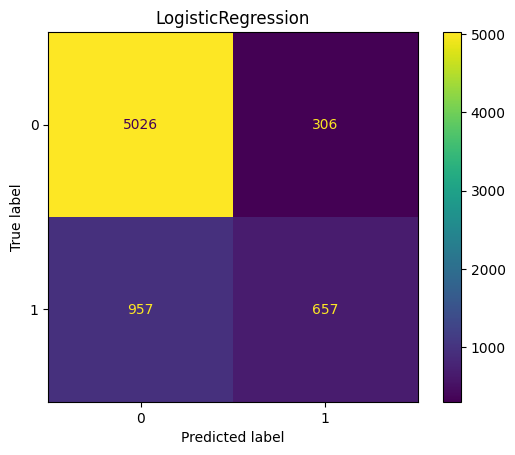

                  Model   Accuracy  F1 Score
0  KNeighborsClassifier  79.470199   0.46791
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      5332
           1       0.59      0.39      0.47      1614

    accuracy                           0.79      6946
   macro avg       0.71      0.65      0.67      6946
weighted avg       0.78      0.79      0.78      6946



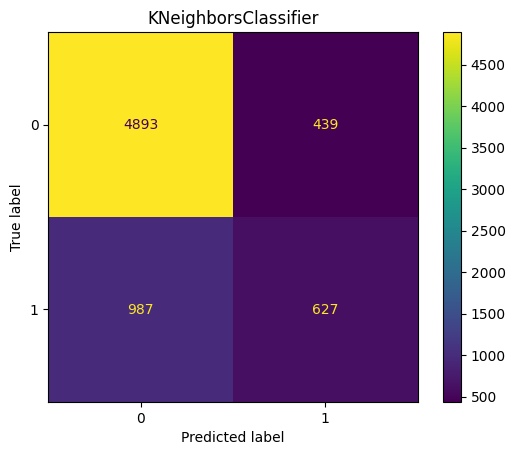

                    Model   Accuracy  F1 Score
0  RandomForestClassifier  81.269796  0.497489
              precision    recall  f1-score   support

           0       0.84      0.94      0.88      5332
           1       0.66      0.40      0.50      1614

    accuracy                           0.81      6946
   macro avg       0.75      0.67      0.69      6946
weighted avg       0.80      0.81      0.79      6946



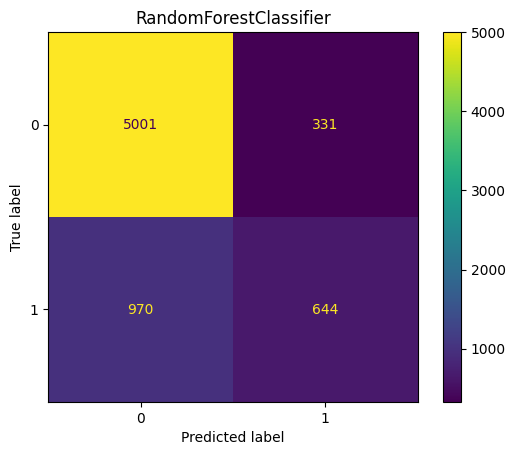

,Model,Accuracy,F1 Score
0,LogisticRegression,81.816873,0.509895
1,KNeighborsClassifier,79.470199,0.467910
2,RandomForestClassifier,81.269796,0.497489


In [521]:
results_df = pd.DataFrame()
# Plot output visualisations and create a table of results
for model in models:
    output = model_output(model, X_test, y_test)
    results_df = pd.concat([results_df, output], ignore_index = True)

results_df

## Model Evaluation

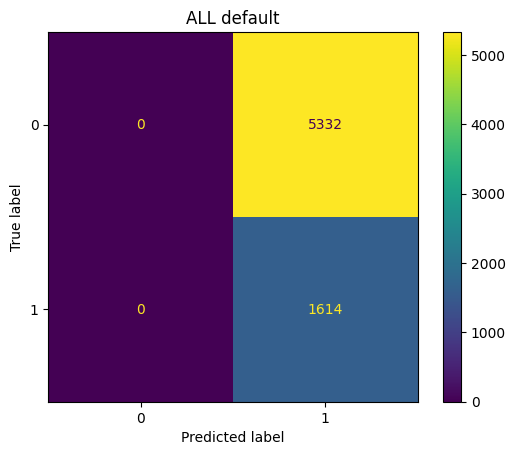

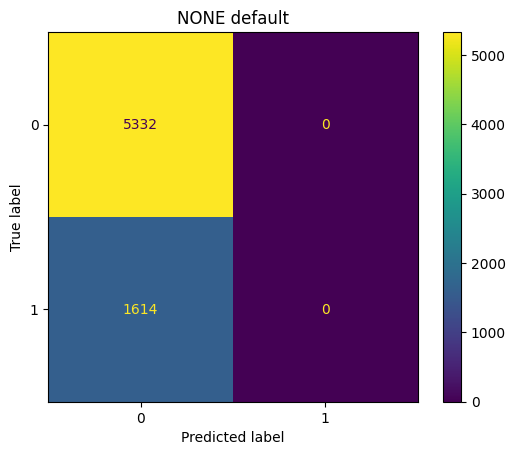

,Model,Accuracy,F1 Score,Macro F1 Score
0,Naive - none default,76.763605,0.000000,0.434273
1,Naive - all default,23.236395,0.377103,0.188551


In [522]:
macro_f1_all_default = f1_score(y_test, np.ones_like(y_test), average = 'macro')
macro_f1_no_default = f1_score(y_test, np.zeros_like(y_test), average = 'macro')

f1_all_default = f1_score(y_test, np.ones_like(y_test))
f1_no_default = f1_score(y_test, np.zeros_like(y_test))

accuracy_all_default = accuracy_score(y_test, np.ones_like(y_test))*100
accuracy_no_default = accuracy_score(y_test, np.zeros_like(y_test))*100


plot_confusion_matrix(y_test, np.ones_like(y_test), title='ALL default')
plot_confusion_matrix(y_test, np.zeros_like(y_test), title='NONE default')

results_dict_naive = {'Model': ['Naive - none default', 'Naive - all default'],
                    'Accuracy': [accuracy_no_default,accuracy_all_default],
                    'F1 Score': [f1_no_default,f1_all_default],
                    'Macro F1 Score': [macro_f1_no_default,macro_f1_all_default]}
results_df_naive = pd.DataFrame(results_dict_naive)
results_df_naive

We compute the F1 scores of two naive estimators. One that always predicts default and one that always predicts non-default. Each of the performance metrics are discussed below.

### Accuracy Score

\begin{equation*}
Accuracy = \frac{Number\:of\:correct \:predictions}{Total\:numer\:of\:predictions} \times 100
\end{equation*}

The accuracy score simply measures the percentage of correct predictions out of the total number of predictions. While the accuracy score is intuitive and easy to comprehend, there are significant limitations especially when applied to imbalanced data such as this.

With unbalanced data, accuracy measures can be misleadingly as models biased towards predicting the majority outcome will perform better as a high proportion of the time they will be correct. However, such a model would not be very useful in practice as lenders would not have any more ability to protect themselves from future defaults. That is to say: accuracy scores don't account for the higher relative cost of underidentifying defaults compared to overidentifying defaults. It assumes that errors are equally costly (He and Garcia, 2009). A naive model that always predicted non-default would have an accuracy score of 77% (the percentage of the majority case).

For this reason we rely on a the F1 score to evaluate the models.

### F1 score

\begin{equation*}
Precision = \frac{True\:positive}{True\:positive+False\:positive}
\end{equation*}

\begin{equation*}
Recall = \frac{True\:positive}{True\:positive+False\:negative}
\end{equation*}


\begin{equation*}
    F1\:Score = 2 \cdot \frac{Precision \cdot Recall}{Precision+Recall} = \frac{True\:positive}{True\:positive + \frac{1}{2} (False\:positive + False\:negative)}
\end{equation*}

The F1 score is a measure of performance that calculates the harmonic mean between precision and recall. Precision is the proportion of predicted positive observations were truly positive - generally precision increases as the threshold increases. Recall is the proportion of truely positive observations that were predicted to be positive - recall increases monotonically as the threshold decreases. The precision and recall can be calculated for each outcome class. The standard F1 score focuses on the precision and recall of the positive class. A precision-recall curve plots the relationship between precision and recall as the threshold value is varied. 

Using the standard positive-class F1 score, we can see the naive estimator that always predicts non-default performs very poorly ($F1\:score = 0$). That is because there are no true positives. An alternative naive model that always predicts default performs slightly better ($F1\:score = 0.38$).

Extensions of the F1 score take different averages of the F1 scores for each class to give a single score across all classes. The macro F1 score takes a simple average of all classes, the weighted F1 score takes the average weighted by the proportion of each class (the support) and the micro F1 score calculates the F1 score across all observations (Radečić, 2021). 

In default detection we are mostly focused on the model's performance with the positive (defaulting) case. For the remaining analysis we will therefore focus on the standard positive-case F1 score. In practice a researcher will need to use domain knowledge of the relative costs of identifying a default vs identifying a non-default (James et al., 2014). An alternative to precision-recall curve is the ROC curve, however, this metric is less useful in the case of imbalanced data (Saito and Rehmsmeier, 2015).

In the models above, at high threshold values (>0.88 but <1) the precision decreases - increasing the threshold above 0.88 adds more false positives than true positives.

## Random Oversampling

Although Joshi (2002) found that unbalanced datasets only impact model performance when the ratio of minority to majority outcome ratio is greater than 1:10, we can see that all models fail to predict more than half of defaults. Because of this random oversampling is implemented to understand the affect on performance.

Oversampling randomly duplicates instances of the minority case to an extent decided by the reasearcher in order to increase their importance in the model (He and Garcia, 2009).

Using the imblearn library, a RandomOverSampler class is used along with the fit_resample method to implement random oversampling to the training data. In this instance a random set of defaulted observations are duplicated in the data until the number of defaults and non-defaults are equivalent. 

In [523]:
X_train_over, y_train_over = RandomOverSampler().fit_resample(X_train, y_train)
y_train_over.value_counts()

0    12456
1    12456
Name: default, dtype: int64

The number of default cases is now equal to the number of non-default cases.

                Model   Accuracy  F1 Score
0  LogisticRegression  78.894328  0.559495
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      5332
           1       0.54      0.58      0.56      1614

    accuracy                           0.79      6946
   macro avg       0.71      0.71      0.71      6946
weighted avg       0.79      0.79      0.79      6946



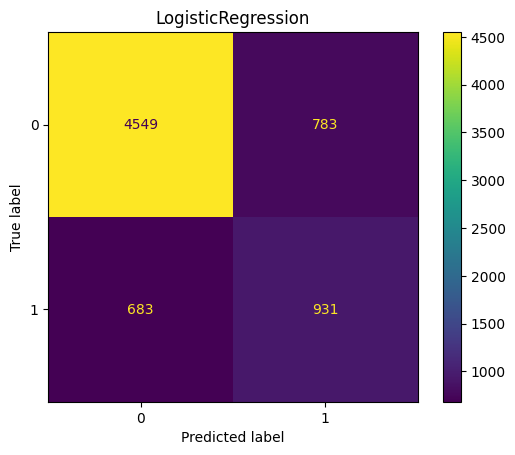

                  Model   Accuracy  F1 Score
0  KNeighborsClassifier  67.492082  0.474395
              precision    recall  f1-score   support

           0       0.86      0.69      0.76      5332
           1       0.38      0.63      0.47      1614

    accuracy                           0.67      6946
   macro avg       0.62      0.66      0.62      6946
weighted avg       0.75      0.67      0.70      6946



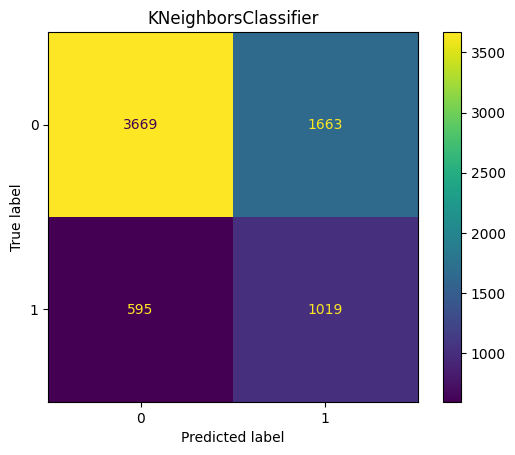

                    Model   Accuracy  F1 Score
0  RandomForestClassifier  81.169018  0.535511
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      5332
           1       0.63      0.47      0.54      1614

    accuracy                           0.81      6946
   macro avg       0.74      0.69      0.71      6946
weighted avg       0.80      0.81      0.80      6946



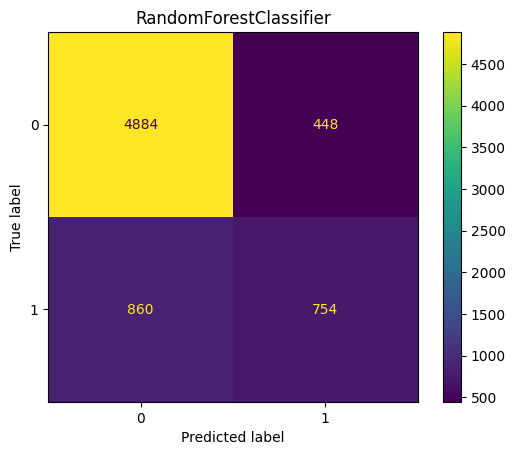

,Model,Accuracy,F1 Score
0,LogisticRegression,78.894328,0.559495
1,KNeighborsClassifier,67.492082,0.474395
2,RandomForestClassifier,81.169018,0.535511


In [524]:
# Fit the models using the oversampled training data
for model in models:
    model.fit(X_train_over, y_train_over)

results_df_over = pd.DataFrame()
# Plot output visualisations and create a table of results
for model in models:
    output = model_output(model, X_test, y_test)
    results_df_over = pd.concat([results_df_over, output], ignore_index = True)

results_df_over

In [525]:

# Indicate results are oversamples
results_df_over['Model'] = results_df_over['Model'].apply(lambda x: x + ' - Oversampling')

# Add the oversampled results to the results df
results_df_comb = pd.concat([results_df, results_df_over, results_df_naive.drop(['Macro F1 Score'], axis = 1)
], ignore_index=True) 
results_df_comb

,Model,Accuracy,F1 Score
0,LogisticRegression,81.816873,0.509895
1,KNeighborsClassifier,79.470199,0.467910
2,RandomForestClassifier,81.269796,0.497489
3,LogisticRegression - Oversampling,78.894328,0.559495
4,KNeighborsClassifier - Oversampling,67.492082,0.474395
5,RandomForestClassifier - Oversampling,81.169018,0.535511
6,Naive - none default,76.763605,0.000000
7,Naive - all default,23.236395,0.377103


The table above shows that oversampling has increased the F1 score across all models. However, this comes at the cost of increased computational time, which would have a greater effect as the number of observations and model complexity increased. The models are also slightly worse at identifying non-defaults.

## Hyperparameter tuning

Each of the models also has hyperparameters - that is parameters that can be adjusted by the researcher. To optimise out-of-sample performance it is best to evaluate the models using multiple hyperparameter values.

As with train-test splits, it is important that hyperparameter selection is not based on testing data in order to prevent overfitting to testing data and leading to poor future performance. In order to not further limit the size of the training and testing data, K-fold cross validation is implemented. K-fold cross validation splits the training data into a number of folds (K), in this case 5. Kohavi (1995) suggests that 10 folds is optimal, however, this comes at a significant computational cost. 

To implement hyperparameter tuning, the researcher must first decide which hyperparameters to vary and the range over which to vary them. For the KNeighboursClassifier the number of neighbours is varied and for the RandomForestClassifier the number of tress and maximum tree depth are varied. The range to vary the values over first starts high and has been narrowed to identify a global maximum in terms of F1 score.

The code below implements K-fold cross validation to identify the optimal hyperparameters within the pescribed range, plots the model performance for each hyperparameter value (combination in the case of RandomForest) and then calculates the out-of-sample performance using the optimal hyperparameter values.


Optimal hyperparameter selection:


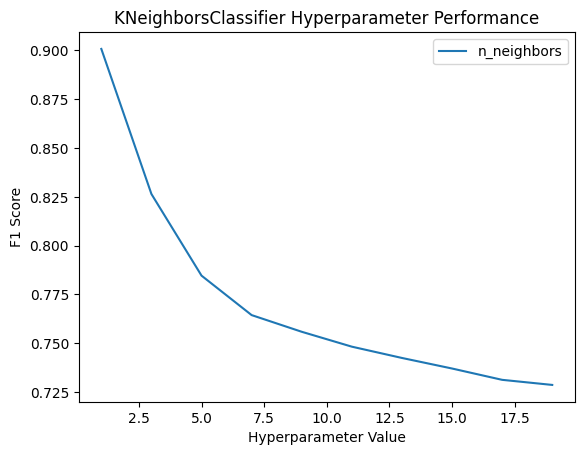

KNeighborsClassifier best parameters: {'n_neighbors': 1}
KNeighborsClassifier best F1 score in validation: 0.9008041863168904

Model performance using optimal hyperparameters on test data:

                  Model   Accuracy  F1 Score
0  KNeighborsClassifier  73.250792  0.430411
              precision    recall  f1-score   support

           0       0.83      0.82      0.83      5332
           1       0.43      0.43      0.43      1614

    accuracy                           0.73      6946
   macro avg       0.63      0.63      0.63      6946
weighted avg       0.73      0.73      0.73      6946



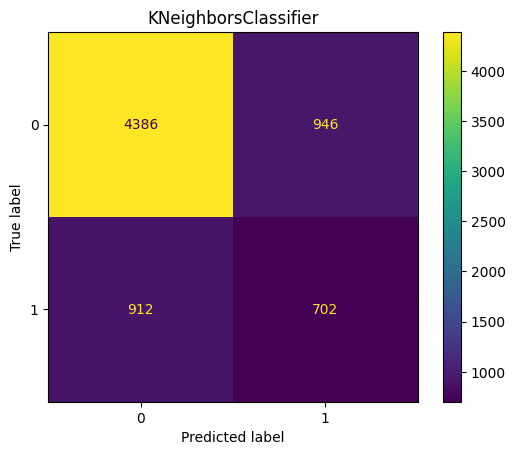


Optimal hyperparameter selection:


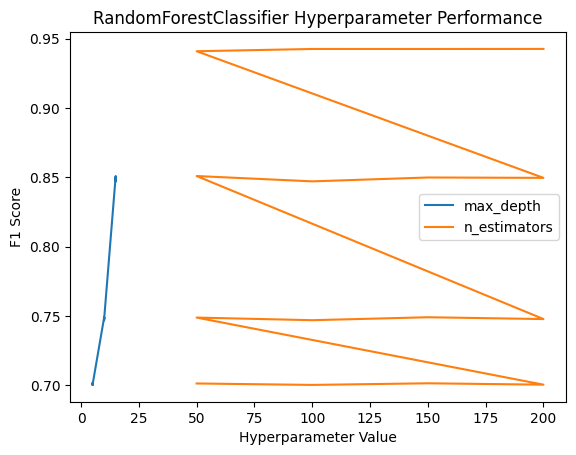

RandomForestClassifier best parameters: {'max_depth': None, 'n_estimators': 200}
RandomForestClassifier best F1 score in validation: 0.9425367662276474

Model performance using optimal hyperparameters on test data:

                    Model   Accuracy  F1 Score
0  RandomForestClassifier  81.269796  0.536516
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      5332
           1       0.63      0.47      0.54      1614

    accuracy                           0.81      6946
   macro avg       0.74      0.69      0.71      6946
weighted avg       0.80      0.81      0.80      6946



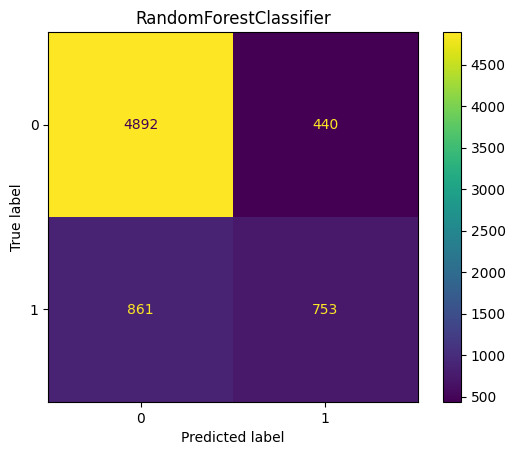

{KNeighborsClassifier(): 0.4304107909258123, RandomForestClassifier(): 0.5365158532240826}


,Model,Accuracy,F1 Score
0,KNeighborsClassifier,73.250792,0.430411
1,RandomForestClassifier,81.269796,0.536516


In [526]:
# Define a list of models and their corresponding parameter grids
models = [
    (KNeighborsClassifier(), {'n_neighbors': np.arange(1, 20, 2)}), 
    (RandomForestClassifier(), {'max_depth': np.append(np.arange(5, 20, 5), None), 'n_estimators': np.arange(50, 250, 50)})
]

# Define a custom F1 scorer
f1_scorer = make_scorer(f1_score, pos_label = 1) 

# Create empty dict to store test scores
test_score = {}

# Create empty dataframe to store results in
results_df_tuned = pd.DataFrame()

# Loop through the models and conduct the grid search with 5-fold cross-validation for each
for model, param_grid in models:

    # Use gird search to measure model performance with each parameter value
    grid = GridSearchCV(model, param_grid, cv=5, scoring=f1_scorer, error_score='raise')

    # Fit the model with all sets of parameters using oversampled training data
    grid.fit(X_train_over, y_train_over) 

    print('\nOptimal hyperparameter selection:')

    # Plot the results of the grid search
    plt.title(f"{model.__class__.__name__} Hyperparameter Performance")
    plt.xlabel("Hyperparameter Value")
    plt.ylabel("F1 Score")
    for param_name in grid.cv_results_['params'][0].keys():
        plt.plot(grid.cv_results_['param_' + param_name], 
                 grid.cv_results_['mean_test_score'], 
                 label=param_name) # mean_test_score refers to the CV tests
    plt.legend()
    plt.show()

    # Print parameters that give the best results along with the score
    print(f"{model.__class__.__name__} best parameters: {grid.best_params_}")
    print(f"{model.__class__.__name__} best F1 score in validation: {grid.best_score_}")

    best_model = grid.best_estimator_

    print('\nModel performance using optimal hyperparameters on test data:\n')
  
    # Evaluate the model on the test set and add to the dictionary
    test_score[model] = f1_score(y_test, 
                                 best_model.predict(X_test),
                                 pos_label = 1)
    
    output = model_output(best_model, X_test, y_test)
    results_df_tuned = pd.concat([results_df_tuned, output], ignore_index = True)

print(test_score)
results_df_tuned

K-nearest neighbour:

The optimal number of neighbours for nearest neighbour is 1. Precision-recall when K = 1 is a straight line as changing the threshold value for values $0>T<1$ will not change the predicted outcome - it will always be that of the nearest observation in the the training data.

Random forest model:

The optimal depth of tree is 50 and number of trees 40 for the Random Forest model.

## Results

In [527]:
# Indicate results are oversamples and hyper parameter tuned
results_df_tuned['Model'] = results_df_tuned['Model'].apply(lambda x: x + ' - Oversampled and Hyperparameter tuned')

# Add the oversampled results to the results df
results_df_comb = pd.concat([results_df_comb, results_df_tuned], ignore_index=True) 
results_df_comb.sort_values(by = 'F1 Score', ascending = False)

,Model,Accuracy,F1 Score
3,LogisticRegression - Oversampling,78.894328,0.559495
9,RandomForestClassifier - Oversampled and Hyper...,81.269796,0.536516
5,RandomForestClassifier - Oversampling,81.169018,0.535511
0,LogisticRegression,81.816873,0.509895
2,RandomForestClassifier,81.269796,0.497489
4,KNeighborsClassifier - Oversampling,67.492082,0.474395
1,KNeighborsClassifier,79.470199,0.467910
8,KNeighborsClassifier - Oversampled and Hyperpa...,73.250792,0.430411
7,Naive - all default,23.236395,0.377103
6,Naive - none default,76.763605,0.000000


The table above shows the performance of each model used in this analysis, sorted by the evaluation metrics of choice, the F1 score.

The logistic regression based on the oversampled dataset performs best on this basis. All of the models outperform the two naive models of always predicting default or non-default. This indicates that a lender would likely benefit from implementing one of the models to anticipate costly defaults.

Interestingly, hyperparameter tuning does not improve the performance of the model on testing data. This indicates that cross validation results do not accurately reflect the test results. This could be because the training data doesn't accurately reflect the testing data (due to oversampling). In the appendix the same hyperparameter tuning is run without oversampling. It shows that oversampling improves RFM but not KNN.

Also, to note, the accuracy score shows a different ranking of models with the simple logisitic regression performing best. However, most of the models' accuracy are close to the percentage of negative cases. This shows the weakness of using accuracy scores on unbalanced data.



## Conclusion

In this analysis we have used individual credit card data to build a binary classification model in order to predict default. As explained earlier, accurate prediction of credit card default will allow a lender to better manage cash flow, as well as supporting the lender to reduce financial distress.

The raw data required significant cleaning and preprocessing to improve performance in modelling, including one-hot encoding, standardisation and removing erroneous entries. Importantly, given the high cost of underpredicting defaults, we also used oversampling techniques to improve prediction of the minority class, default.

In the modelling stage, we explored the performance of three different classification models: logistic regression, k-nearest neighbours and random forest models. And for the later two models, we also performed hyperparameter tuning. Different evaluation metrics were considered based on the focus of the problem. The positive-case F1-score was chosen based on the understanding of the relative costs of over vs under prediction of default. 

Using this metrics we ranked 7 different models and compared to 2 naive models to understand the improvements. We found that all of the models outperformed the naive models, with the oversampled logisitic regression model performing the best.

Future work may quantify the costs to the lender of under or over predicting default accurately. This would allow an data scientist to make a more informed decision of the best evaluation metric. Futhermore, the researcher would likely want to explore more models and hyperparameters - however, this is costly in terms of computing time.

## Annex 1


Optimal hyperparameter selection:


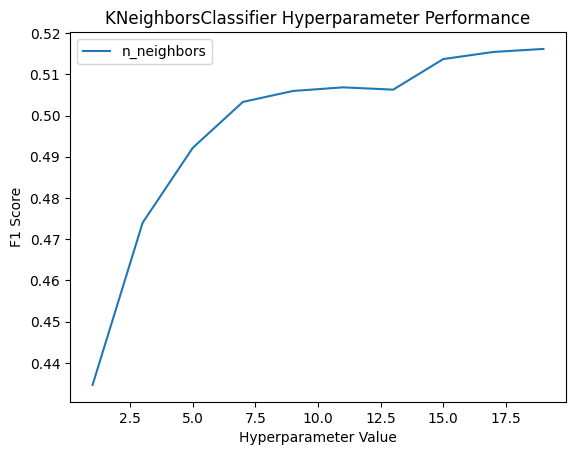

KNeighborsClassifier best parameters: {'n_neighbors': 19}
KNeighborsClassifier best F1 score in validation: 0.5161599051078236

Model performance using optimal hyperparameters on test data:

                  Model   Accuracy  F1 Score
0  KNeighborsClassifier  81.586525  0.511646
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      5332
           1       0.67      0.42      0.51      1614

    accuracy                           0.82      6946
   macro avg       0.75      0.68      0.70      6946
weighted avg       0.80      0.82      0.80      6946



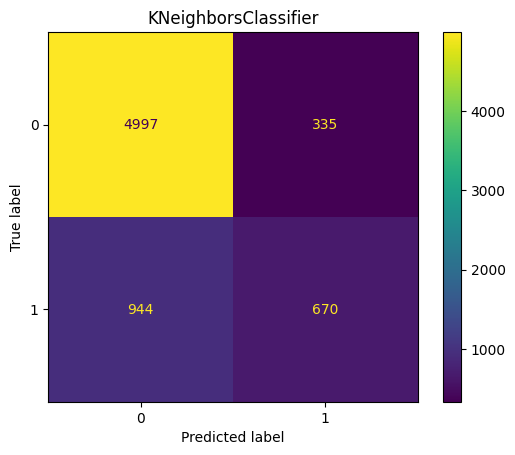


Optimal hyperparameter selection:


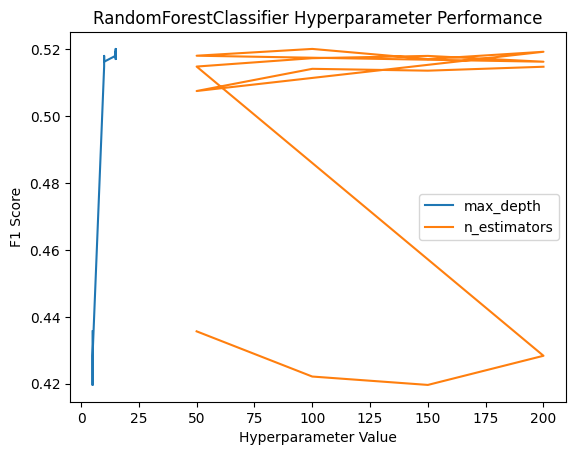

RandomForestClassifier best parameters: {'max_depth': 15, 'n_estimators': 100}
RandomForestClassifier best F1 score in validation: 0.5201676151848245

Model performance using optimal hyperparameters on test data:

                    Model   Accuracy  F1 Score
0  RandomForestClassifier  81.269796  0.497101
              precision    recall  f1-score   support

           0       0.84      0.94      0.88      5332
           1       0.66      0.40      0.50      1614

    accuracy                           0.81      6946
   macro avg       0.75      0.67      0.69      6946
weighted avg       0.80      0.81      0.79      6946



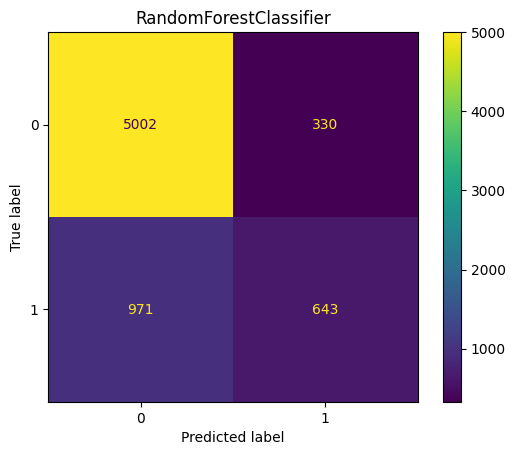

{KNeighborsClassifier(): 0.5116456662848415, RandomForestClassifier(): 0.49710088906068806}


,Model,Accuracy,F1 Score
0,KNeighborsClassifier,81.586525,0.511646
1,RandomForestClassifier,81.269796,0.497101


In [528]:
# Define a list of models and their corresponding parameter grids
models = [
    (KNeighborsClassifier(), {'n_neighbors': np.arange(1, 20, 2)}), 
    (RandomForestClassifier(), {'max_depth': np.append(np.arange(5, 20, 5), None), 'n_estimators': np.arange(50, 250, 50)})
]

# Define a custom F1 scorer
f1_scorer = make_scorer(f1_score, pos_label = 1) 

# Create empty dict to store test scores
test_score = {}

# Create empty dataframe to store results in
results_df_tuned_no_over = pd.DataFrame()

# Loop through the models and conduct the grid search with 5-fold cross-validation for each
for model, param_grid in models:

    # Use gird search to measure model performance with each parameter value
    grid = GridSearchCV(model, param_grid, cv=5, scoring=f1_scorer, error_score='raise')

    # Fit the model with all sets of parameters using oversampled training data
    grid.fit(X_train, y_train) 

    print('\nOptimal hyperparameter selection:')

    # Plot the results of the grid search
    plt.title(f"{model.__class__.__name__} Hyperparameter Performance")
    plt.xlabel("Hyperparameter Value")
    plt.ylabel("F1 Score")
    for param_name in grid.cv_results_['params'][0].keys():
        plt.plot(grid.cv_results_['param_' + param_name], 
                 grid.cv_results_['mean_test_score'], 
                 label=param_name) # mean_test_score refers to the CV tests
    plt.legend()
    plt.show()

    # Print parameters that give the best results along with the score
    print(f"{model.__class__.__name__} best parameters: {grid.best_params_}")
    print(f"{model.__class__.__name__} best F1 score in validation: {grid.best_score_}")

    best_model = grid.best_estimator_

    print('\nModel performance using optimal hyperparameters on test data:\n')
  
    # Evaluate the model on the test set and add to the dictionary
    test_score[model] = f1_score(y_test, 
                                 best_model.predict(X_test),
                                 pos_label = 1)
    
    output = model_output(best_model, X_test, y_test)
    results_df_tuned_no_over = pd.concat([results_df_tuned_no_over, output], ignore_index = True)

print(test_score)
results_df_tuned_no_over

In [529]:
# Indicate results are oversamples and hyper parameter tuned
results_df_tuned_no_over['Model'] = results_df_tuned_no_over['Model'].apply(lambda x: x + ' - Hyperparameter tuned')

# Add the oversampled results to the results df
results_df_comb = pd.concat([results_df_comb, results_df_tuned_no_over], ignore_index=True) 
results_df_comb.sort_values(by = 'F1 Score', ascending = False)

,Model,Accuracy,F1 Score
3,LogisticRegression - Oversampling,78.894328,0.559495
9,RandomForestClassifier - Oversampled and Hyper...,81.269796,0.536516
5,RandomForestClassifier - Oversampling,81.169018,0.535511
10,KNeighborsClassifier - Hyperparameter tuned,81.586525,0.511646
0,LogisticRegression,81.816873,0.509895
2,RandomForestClassifier,81.269796,0.497489
11,RandomForestClassifier - Hyperparameter tuned,81.269796,0.497101
4,KNeighborsClassifier - Oversampling,67.492082,0.474395
1,KNeighborsClassifier,79.470199,0.467910
8,KNeighborsClassifier - Oversampled and Hyperpa...,73.250792,0.430411


# References

Hastie, T., Tibshirani, R., & Friedman, J. H. (2009). The elements of statistical learning: data mining, inference, and prediction. 2nd ed. New York, Springer.

H. He and E. A. Garcia, 2009, "Learning from Imbalanced Data," in IEEE Transactions on Knowledge and Data Engineering, vol. 21, no. 9, pp. 1263-1284 , doi: 10.1109/TKDE.2008.239.

James, G., Witten, D., Hastie, T., & Tibshirani, R. (2014). An Introduction to Statistical Learning: with Applications in R. Springer Publishing Company, Incorporated. p.150

Joshi, M. (2002). ”Learning Classifier Models for Predicting Rare Phonemena.” PhD thesis, University of Minnesota.

Kohavi, R. (1995). ”A study of cross-validation and bootstrap for accuracy estimation and model selection.” In Proceedings of the 14th international joint conference on Artificial intelligence - Volume 2 (IJCAI’95). Morgan Kaufmann Publishers Inc., San Francisco, CA, USA, 1137–1143.

Paper, (2020). Hands-on Scikit-Learn for Machine Learning Applications. Apress Berkeley, CA; p29

Provost, F.J., Fawcett, T.: Robust classification for imprecise environments. Mach. Learn. 42(3), 203–231 (2001)

Radečić, D. (2021). Micro, Macro, Weighted Averages of F1 Score — Clearly Explained. Towards Data Science. Retrieved March 18, 2023, from https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f#33e1

Saito, Takaya & Rehmsmeier, Marc. (2015). The Precision-Recall Plot Is More Informative than the ROC Plot When Evaluating Binary Classifiers on Imbalanced Datasets. PloS one. 10. e0118432. 10.1371/journal.pone.0118432. 

Schonlau, M., & Zou, R. Y. (2020). ”The random forest algorithm for statistical learning.” The Stata Journal,
20(1), 3–29

Yeh, I. C., & Lien, C. H. (2009). ”The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients.” Expert Systems with Applications, 36(2), 2473-2480.6


## Unit Testing

In [530]:
class TestNotebook(unittest.TestCase):
    """
    This is a test class to test the methods defined in the code above.
    """   
    
    def setUp(self):
        
        # Set up a connected graph to be used in test methods.
        self.d = {'col_1':['A', 'A', 'B', 'C', 'C'],
             'col_2':['B', 'C', 'A', 'A', 'B']}
        self.df = pd.DataFrame(self.d)

    # Test preprocessor function
    def test_preprocessor(self):

        # Test exception handling when column not in dataframe
        lst = ['col_3'] 
        self.assertRaises(KeyError, preprocessor, self.df, lst)
        
        # Test output object type when valid columns are provided
        lst_cor = ['col_1', 'col_2']
        assert isinstance(preprocessor(self.df, lst_cor), pd.DataFrame)
        
unittest.main(argv=[''], verbosity=1, exit=False)

.
----------------------------------------------------------------------
Ran 1 test in 0.013s

OK


A    2
C    2
B    1
Name: col_1, dtype: int64
B    2
A    2
C    1
Name: col_2, dtype: int64
